# Finding the way out in a maze

## 1. Let's start with the OpenAI gym

Gym (https://gym.openai.com/) is a wide-used toolkit for developing and comparing reinforcement learning algorithms. 

1. Gym makes no assumptions about the structure of your agent, and is compatible with any numerical computation library, such as TensorFlow or Theano. 

2. The gym library is a collection of test problems — **environments** — that you can use to work out your reinforcement learning algorithms. These environments have a shared interface, allowing you to write general algorithms.

In [1]:
!pip install gym
import gym

## 2. Model the practical task into a MDP

To solve a RL problem, we start with formalizing the problem into a MDP model. Please describe this MDP model in your report. 

Notice: No empricial data provided in this assignment, so the point of 'data description and exploration' will be given to this step. 

While exploring your MDP model, you shall think about questions such as:
- What is the environment? How does it look like?
- What simulated data can your RL agent observe from the environment? How does it look like?
- Which data is considered as the state? Which data is considered as the reward?

### 2.1 Set up the environment

There is no need to implement your own environment. You can use the environment we provide in the file **environment.py**. But please make sure to have a look at it, so that you understand the inner working of this environment.

The core gym interface is **Env**, which is the unified environment interface. The following are the Env methods you should know:

- reset(self): Reset the environment's state. Returns observation.
- step(self, action): Step the environment by one timestep. Returns observation, reward, done, info. 
- render(self, mode='rgb_array'): Render one frame of the environment. The default mode will do something human friendly, such as pop up a window. In this assignment, there is no need to create a pop up window. 

Please notice that you need to first install the [mazelab](https://github.com/zuoxingdong/mazelab) package for running the environment (a file with required packages is also given). If you run the below cell the first time. Make sure to restart the ipython notebook at least once.

In [ ]:
!pip install scikit-image==0.15.0
!pip install seaborn tqdm
!git clone https://github.com/zuoxingdong/mazelab.git
!pip install -r mazelab/requirements.txt
!pip install -e mazelab

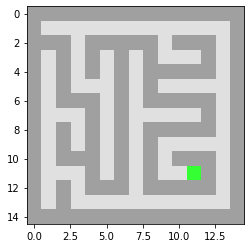

In [1]:
from IPython import get_ipython
import random
from mazelab.generators import random_maze, morris_water_maze
import matplotlib.pyplot as plt
from IPython import display
from mazelab.solvers import dijkstra_solver
import seaborn as sns
from tqdm.notebook import tqdm
from others.environment import TaskEnv
from typing import Tuple, List
import itertools as it
import numpy as np
import pandas as pd

def animate_run(data:List[np.ndarray]):
    init_img = data[0]
    remaining_img = data[1:]
    img_container = plt.imshow(init_img)  # only call this once
    for img in remaining_img:
        img_container.set_data(img)  # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)


def visualize_agent_brain(agent, env: TaskEnv):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.set_title("Highest state value at position (x,y)")
    state_value_map = agent.q_table.max(axis=2)
    sns.heatmap(state_value_map, ax=ax1)

    ax2.set_title("Chosen action at position (x,y)")
    n = env.action_space.n + 1
    path = env.maze.objects.free.positions
    decisions_map = np.array([[x_, y_, agent.select_action([x_, y_]) + 1] for x_, y_ in path])
    state_action_map = np.zeros_like(agent.q_table.max(axis=2))
    state_action_map[decisions_map[:, 0], decisions_map[:, 1]] = decisions_map[:, 2]
    cmap = sns.color_palette("viridis", n)
    sns.heatmap(state_action_map, cmap=cmap, ax=ax2)
    colorbar = ax2.collections[0].colorbar
    r = (colorbar.vmax) - colorbar.vmin
    colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
    colorbar.set_ticklabels(['N/A', 'north', 'south', 'west', 'east'])
    fig.tight_layout()
    return plt.show()

env = TaskEnv()
env.reset()
impassable_array = env.unwrapped.maze.to_impassable()
motions = env.unwrapped.motions
start = env.unwrapped.maze.objects.agent.positions[0]
goal = env.unwrapped.maze.objects.goal.positions[0]
actions = dijkstra_solver(impassable_array, motions, start, goal)
print(actions)

imgs = []
rewards = 0.0
for action in actions:
    _, reward, _, _ = env.step(action)
    rewards += reward
    imgs.append(env.render("rgb_array"))

animate_run(imgs)
plt.show()

### 2.2  Implement the agents 

In this part, you are expected to implement two RL agents. 

- Agent 1 uses the Q-learning algorithm to learn the optimal solution
- Agent 2 uses the SARSA algorithm to learn the optimal solution. To decide the action to take at each time step,  this agent uses the epsilon greedy action selection.

In [2]:
# Random agent
class RandomAgent():
    def __init__(self,
                 env: TaskEnv,
                 exploration_rate: float = None,
                 learning_rate: float = None,
                 discount_factor: float = None) -> int:
        self.epsilon = 1  # A random agent "explores" always, so epsilon will be 1
        self.alpha = 0  # A random agent never learns, so there's no need for a learning rate
        self.gamma = 0  # A random agent does not update it's q-table. Hence, it's zero.
        self.q_table = np.zeros(env.observation_space.shape + (env.action_space.n, ), dtype=float)
        self.actions = env.action_space

    def select_action(self, state: Tuple[int, int], use_greedy_strategy: bool = False) -> int:
        if not use_greedy_strategy:
            if random.random() < self.epsilon:
                next_action = self.actions.sample()
                return next_action

        x, y = state
        max_val = np.max(self.q_table[x, y, :])
        find_max_val = np.where(self.q_table[x, y, :] == max_val)
        next_action = np.random.choice(find_max_val[0])
        return next_action

    def learn(self, state, action, next_state, reward, done):
        return None


### Q-learning

In [3]:
import numpy as np

class QAgent(): 
    def __init__(self, env: TaskEnv, epsilon: float, learning_rate: float, discount_factor: float):
        self.epsilon = epsilon
        self.alpha = learning_rate
        self.gamma = discount_factor
        self.q_table = np.zeros(env.observation_space.shape + (env.action_space.n, ), dtype=float)
        self.actions = env.action_space
    
    def select_action(self, state: Tuple[int, int], use_greedy_strategy: bool = False) -> int:
        if not use_greedy_strategy:
            if random.random() < self.epsilon:
                next_action = self.actions.sample()
                return next_action

        x, y = state
        max_val = np.max(self.q_table[x, y, :])
        find_max_val = np.where(self.q_table[x, y, :] == max_val)
        next_action = np.random.choice(find_max_val[0])
        return next_action

    def learn(self, env: TaskEnv, episodes: int):
        counts = []
        rewards = []
        for episode in range(episodes):
            state = env.reset()
            score = 0
            counter = 0
            while True:
                action = self.select_action(state)
                next_state, reward, done, _ = env.step(action)
                if done:
                    max_next_reward = 0
                else:
                    next_x, next_y = next_state
                    greedy_step = self.select_action(next_state, use_greedy_strategy=True)
                    max_next_reward = self.q_table[next_x, next_y, greedy_step]
                self.update_Q_table(state, action, reward, max_next_reward, done)
                state = next_state
                score += reward
                counter += 1
                if done:
                    counts.append(counter)
                    break
            rewards.append(score)
        env.close()
        return [counts, rewards]

    def update_Q_table(self, current_state, current_action, reward, max_next_Q, done):
        x, y = current_state
        current_Q = self.q_table[x, y, current_action]
        if done:
            new_Q = reward
        else:
            target = reward + self.gamma * (max_next_Q - current_Q)
            new_Q = current_Q + self.alpha * target
        self.q_table[x, y, current_action] = new_Q

    def export_Q_table(self):
        np.savetxt("Q_table.csv", self.q_table.reshape((3, -1)), delimiter=",", fmt='%s')

### SARSA

In [4]:
import numpy as np

class SarsaAgent():
    def __init__(self, env: TaskEnv, epsilon: float, learning_rate: float, discount_factor: float):
        self.epsilon = epsilon
        self.alpha = learning_rate
        self.gamma = discount_factor
        self.q_table = np.zeros(env.observation_space.shape + (env.action_space.n, ), dtype=float)
        self.actions = env.action_space
    
    def select_action(self, state: Tuple[int, int]):
        if random.random() < self.epsilon:
            next_action = self.actions.sample()
            return next_action

        x, y = state
        max_val = np.max(self.q_table[x, y, :])
        find_max_val = np.where(self.q_table[x, y, :] == max_val)
        next_action = np.random.choice(find_max_val[0])
        return next_action

    def learn(self, env: TaskEnv, episodes: int):
        counts = []
        rewards = []
        for episode in range(episodes):
            state = env.reset()
            action = self.select_action(state)
            score = 0
            counter = 0
            while True:
                next_state, reward, done, _ = env.step(action)
                next_action = self.select_action(next_state)
                self.update_Q_table(state, action, reward, next_state, next_action, done)
                state, action = next_state, next_action
                score += reward
                counter += 1
                if done:
                    counts.append(counter)
                    break
            rewards.append(score)
        env.close()
        return [counts, rewards]

    def update_Q_table(self, current_state, current_action, reward, next_state, next_action, done):
        x, y = current_state
        current_Q = self.q_table[x, y, current_action]
        if done:
            next_Q = reward
        else:
            x_next, y_next = next_state
            next_Q = reward + (self.gamma * self.q_table[x_next, y_next,next_action])
        self.q_table[x, y, current_action] += self.alpha * (next_Q - current_Q)

    def export_Q_table(self):
        np.savetxt("Q_table.csv", self.q_table.reshape((3, -1)), delimiter=",", fmt='%s')


### 2.3 Run the simulation

Now, we write the codes for running a simulation. In each run, you shall setup the epsilon parameter. 

In [5]:
# Initialize the environment
env = TaskEnv()
env.reset()
impassable_array = env.unwrapped.maze.to_impassable()
motions = env.unwrapped.motions
start = env.unwrapped.maze.objects.agent.positions[0]
goal = env.unwrapped.maze.objects.goal.positions[0]

# Define model parameters
parameters = {
    'env': env,
    'epsilon': 0.01,
    'learning_rate': 0.9,
    'discount_factor': 0.9,
}

In [6]:
Q_agent = QAgent(**parameters)
qlearning_steps, qlearning_rewards = Q_agent.learn(env, 1000)

In [7]:
sarsa_agent = SarsaAgent(**parameters)
sarsa_steps, sarsa_rewards = sarsa_agent.learn(env, 1000)

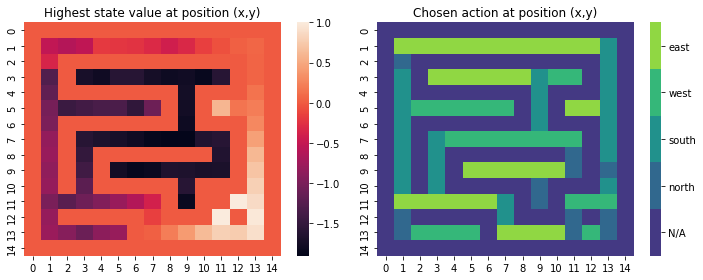

In [8]:
visualize_agent_brain(Q_agent, env)

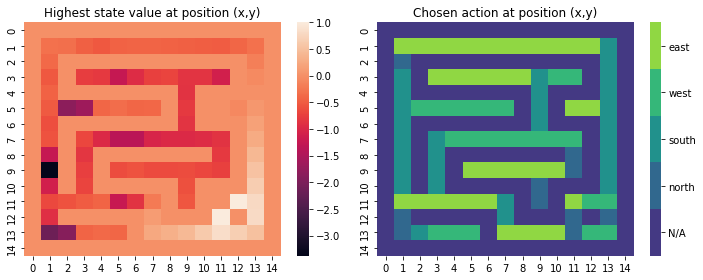

In [9]:
visualize_agent_brain(sarsa_agent, env)

 ## 3. Play with parameters and analyse results
 
Finally, you will describe, evaluate and interpret your results from two RL agents, as well as compare your agents with the given Random agent. Feel free to use the provided helper functions for evaluating your agents. Some points are good to notice:

- Both quantified evaluation and human evaluation are needed in the report. The quantified evaluation shall focus on the measurement of reward. In human evaluation, you can use the provided visual tools to interpret your results. Your report shall include at least one plot presenting comparable measures of the different agents. 

- While evaluating the results of Agent 2 (with SARSA algorithm), please try at least 2 different values of **epsilon** (expect 0) and discuss the influence of different epsilon values on results. In the end, please identify a reasonable epsilon value that could balance the exploration and exploitation, then fix this value for comparing two agents. Present your trails and results in the report.

- In the report, you also need to parcitularly describe and discuss the similarity and difference of results from two RL agents (hint: on-policy VS off-policy). For this, please make sure that the compared results are obtained from the same environment (a same maze for two different agents). Also, while evaluating the results of two agents, please try at least 2 different values of **gamma**. In this way, you could discuss the influence of this discount factor in your report. 

- Please run the simulation for multiple times and average them for all your results. 


# Bonus Tasks 

We would like to challenge you with the following bonus task. For each task that is successfully completed, you may obtain max. 1 extra point. 

1. Implement a third RL agent using another RL algorithm (e.g. Monte Carlo methods, Expected SARSA or even neural network-based ones) and discuss your findings. Compare this third agent with the above ones and explain why this is a better (or worse) RL algorithm. You are allowed to reuse exsiting packages, but please cite them, test them in advance, and make sure that you can explain the used algorithm using your own words.

2. Can you explore and show other evaluation results? If so, implement and present one extra result (e.g. a plot). And please explain why it is a good evaluation for our task or how it shows the difference between two RL agents/algorithms.

In [10]:
#Expected SARSA
import numpy as np

"""
Sarsa is just like Q-learning except that instead of the maximum over next state-action pairs it used the
expected value taking into account how likely each action is under the current policy. 

Expected Sarsa is more complex computationally than Sarsa but, in return, it eliminates the variance due to the
random selection of At+1. Given the same amount of experience we might expect it to perform slightly better
than Sarsa, and indeed it generally does.

expected sarsa can be used in either on-policy or off-policy approaches,
it depends if the policy used to calculate the TD error is the same as that used to select actions.

Expected Sarsa is a variation of Sarsa which exploits this. knowledge to prevent stochasticity in the policy from
further. increasing variance. 
It does so by basing the update, not on. Q(st+1,at+1), but on its expected value E{Q(st+1,at+1)}.

"""

import numpy as np

class ESarsaAgent(): 
    def __init__(self, env: TaskEnv, epsilon: float, learning_rate: float, discount_factor: float):
        self.epsilon = epsilon
        self.alpha = learning_rate
        self.gamma = discount_factor
        self.q_table = np.zeros(env.observation_space.shape + (env.action_space.n, ), dtype=float)
        self.actions = env.action_space

    def get_expected_reward(self, next_state):
        x_next, y_next = next_state
        q_max = np.max(self.q_table[x_next, y_next, :])
        greedy_actions = 0
        for i in range(self.actions.n):
            if self.q_table[x_next, y_next, i] == q_max:
                greedy_actions += 1
        non_greedy_action_probability = self.epsilon / self.actions.n
        greedy_action_probability = ((1 - self.epsilon) / greedy_actions) + non_greedy_action_probability
        expected_q = 0
        for i in range(self.actions.n):
            if self.q_table[x_next, y_next, i] == q_max:
                expected_q += self.q_table[x_next, y_next, i] * greedy_action_probability
            else:
                expected_q += self.q_table[x_next, y_next, i] * non_greedy_action_probability
        return expected_q
    
    def select_action(self, state: Tuple[int, int]):
        if random.random() < self.epsilon:
            next_action = self.actions.sample()
            return next_action

        x, y = state
        max_val = np.max(self.q_table[x, y, :])
        find_max_val = np.where(self.q_table[x, y, :] == max_val)
        next_action = np.random.choice(find_max_val[0])
        return next_action

    def learn(self, env: TaskEnv, episodes: int):
        counts = []
        rewards = []
        for episode in range(episodes):
            state = env.reset()
            score = 0
            counter = 0
            while True:
                action = self.select_action(state)
                next_state, reward, done, _ = env.step(action)
                if done:
                    expected_next_reward = 0
                else:
                    expected_next_reward = self.get_expected_reward(next_state)
                self.update_Q_table(state, action, reward, expected_next_reward, done)
                state = next_state
                score += reward
                counter += 1
                if done:
                    counts.append(counter)
                    break
            rewards.append(float(score))
        env.close()
        return [counts, rewards]

    def update_Q_table(self, current_state, current_action, reward, expected_next_reward, done):
        x, y = current_state
        current_Q = self.q_table[x, y, current_action]
        if done:
            new_Q = reward
        else:
            target = reward + self.gamma * (expected_next_reward - current_Q)
            new_Q = current_Q + target
        self.q_table[x, y, current_action] = new_Q

    def export_Q_table(self):
        np.savetxt("Q_table.csv", self.q_table.reshape((3, -1)), delimiter=",", fmt='%s')


In [11]:
esarsa_agent = ESarsaAgent(**parameters)
esarsa_steps, esarsa_rewards = esarsa_agent.learn(env, 1000)

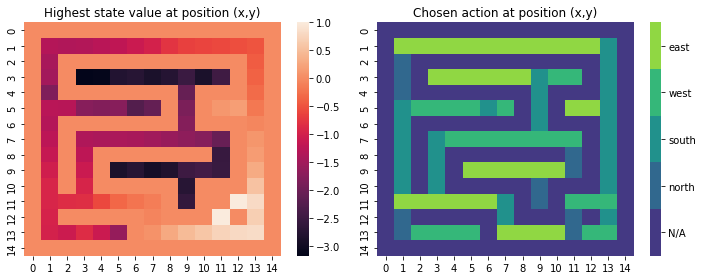

In [12]:
visualize_agent_brain(esarsa_agent, env)

In [13]:
n_of_runs = 20
n_of_episodes = 1000

q_learning_rewards = []
qlearning_steps = []
for n in range(n_of_runs):
    Q_agent = QAgent(**parameters)
    qlearning_step, qlearning_reward = Q_agent.learn(env, n_of_episodes)
    q_learning_rewards.append(qlearning_reward)
    qlearning_steps.append(qlearning_step)

sarsa_rewards = []
sarsa_steps = []
for n in range(n_of_runs):
    sarsa_agent = SarsaAgent(**parameters)
    sarsa_step, sarsa_reward = sarsa_agent.learn(env, n_of_episodes)
    sarsa_rewards.append(sarsa_reward)
    sarsa_steps.append(sarsa_step)

esarsa_rewards = []
esarsa_steps = []
for n in range(n_of_runs):
    ESarsa_agent = ESarsaAgent(**parameters)
    esarsa_step, esarsa_reward = ESarsa_agent.learn(env, n_of_episodes)
    esarsa_rewards.append(esarsa_reward)
    esarsa_steps.append(esarsa_step)

q_learning_rewards = np.average(q_learning_rewards,axis=0)
sarsa_rewards = np.average(sarsa_rewards,axis=0)
esarsa_rewards = np.average(esarsa_rewards,axis=0)

qlearning_steps = np.average(qlearning_steps,axis=0)
sarsa_steps = np.average(sarsa_steps,axis=0)
esarsa_steps = np.average(esarsa_steps,axis=0)

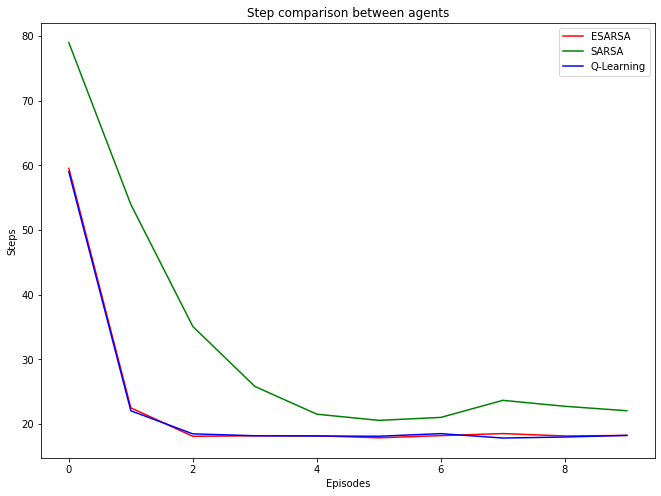

In [14]:
esarsa_steps = np.array_split(esarsa_steps, 10)
sarsa_steps = np.array_split(sarsa_steps, 10)
qlearning_steps = np.array_split(qlearning_steps, 10)

new_esarsa_steps = []
for i in esarsa_steps:
    average = np.average(i)
    new_esarsa_steps.append(average)

new_sarsa_steps = []
for i in sarsa_steps:
    average = np.average(i)
    new_sarsa_steps.append(average)

new_qlearning_steps = []
for i in qlearning_steps:
    average = np.average(i)
    new_qlearning_steps.append(average)

plt.figure(figsize=(11, 8))
plt.plot(new_esarsa_steps, label='ESARSA', color='red')
plt.plot(new_sarsa_steps, label='SARSA', color='green')
plt.plot(new_qlearning_steps, label='Q-Learning', color='blue')
plt.title('Step comparison between agents')
plt.xlabel('Episodes')
plt.ylabel('Steps')
plt.legend()
plt.show()

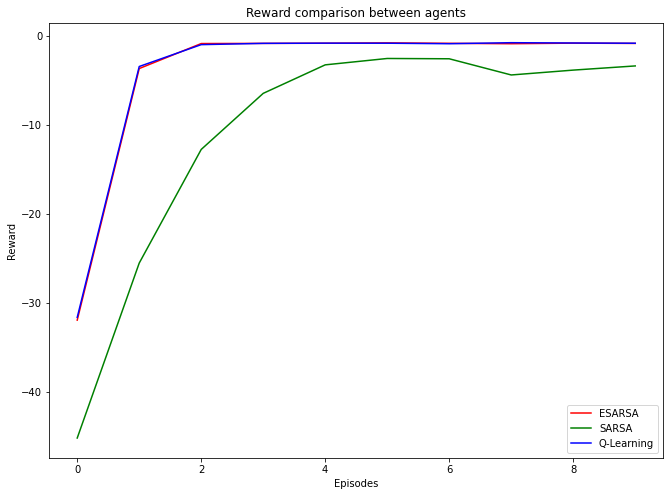

In [15]:
esarsa_rewards = np.array_split(esarsa_rewards, 10)
sarsa_rewards = np.array_split(sarsa_rewards, 10)
q_learning_rewards = np.array_split(q_learning_rewards, 10)

new_esarsa_rewards = []
for i in esarsa_rewards:
    average = np.average(i)
    new_esarsa_rewards.append(average)

new_sarsa_rewards = []
for i in sarsa_rewards:
    average = np.average(i)
    new_sarsa_rewards.append(average)

new_qlearning_rewards = []
for i in q_learning_rewards:
    average = np.average(i)
    new_qlearning_rewards.append(average)

plt.figure(figsize=(11, 8))
plt.plot(new_esarsa_rewards, label='ESARSA', color='red')
plt.plot(new_sarsa_rewards, label='SARSA', color='green')
plt.plot(new_qlearning_rewards, label='Q-Learning', color='blue')
plt.title('Reward comparison between agents')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.legend()
plt.show()